In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

#Performing EDA on Titanic dataset
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
#Removing unnecessary features
for df in [train, test]:
    df.drop(labels = ['PassengerId', 'Cabin', 'Name', 'Ticket'], axis = 1, inplace = True)

In [5]:
#Fill missing values 
for df in [test, train]:
    for col in ['Age', 'Fare']:
        df[col] = df[col].fillna(np.mean(df[col]))

In [6]:
#Data normalization 
min_max_scaler = preprocessing.MinMaxScaler()
for df in [train, test]:
    for col in ['Age', 'Fare']:
        x = df[[col]].values.astype(float)
        df[col] = min_max_scaler.fit_transform(x)

In [7]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,0.452723,0,0,0.015282,Q
1,3,female,0.617566,1,0,0.013663,S
2,2,male,0.815377,0,0,0.018909,Q
3,3,male,0.353818,0,0,0.016908,S
4,3,female,0.287881,1,1,0.023984,S


In [8]:
#transform string
for df in [train, test]:
    #remove duplicate features to avoid overfitting
    #df['is_male'] = np.where(df['Sex']=="male", 1, 0)
    df['is_female'] = np.where(df['Sex']=="female", 1, 0)
    df['EmbarkedS'] = np.where(df['Embarked']=="S", 1, 0)
    df['EmbarkedC'] = np.where(df['Embarked']=="C", 1, 0)
    df['EmbarkedQ'] = np.where(df['Embarked']=="Q", 1, 0)
    df['Pclass1'] = np.where(df['Pclass']==1, 1, 0)
    df['Pclass2'] = np.where(df['Pclass']==2, 1, 0)
    df['Pclass3'] = np.where(df['Pclass']==3, 1, 0)
    df['is_single'] = np.where(np.logical_and(df['SibSp']==0, df['Parch']==0), 1, 0)

In [9]:
#then remove transformed columns
for df in [train, test]:
    df.drop(labels=["Sex", "Embarked", 'Pclass'], axis=1, inplace=True)

In [10]:
test.head()

,Age,SibSp,Parch,Fare,is_female,EmbarkedS,EmbarkedC,EmbarkedQ,Pclass1,Pclass2,Pclass3,is_single
0,0.452723,0,0,0.015282,0,0,0,1,0,0,1,1
1,0.617566,1,0,0.013663,1,1,0,0,0,0,1,0
2,0.815377,0,0,0.018909,0,0,0,1,0,1,0,1
3,0.353818,0,0,0.016908,0,1,0,0,0,0,1,1
4,0.287881,1,1,0.023984,1,1,0,0,0,0,1,0


In [72]:
#load up train/validation set! 
train_size = train.shape[0]

train_dataset = train[:600]
val_dataset = train[601:]

X_train = train_dataset.drop(labels=["Survived"], axis=1).values #.values returns a numpy array, not a Pandas dataframe. An array does not have a columns attribute.
Y_train = train_dataset["Survived"].values

X_val = val_dataset.drop(labels=["Survived"], axis=1).values
Y_val = val_dataset["Survived"].values

input_size = len(train_dataset.columns) - 1# number of final features 

In [73]:
X_train = X_train.reshape((X_train.shape[1], X_train.shape[0]))
X_val = X_val.reshape((X_val.shape[1], X_val.shape[0]))

Y_train = Y_train.reshape((1, Y_train.shape[0]))
Y_val = Y_val.reshape((1, Y_val.shape[0]))

In [74]:
X_train.shape, X_val.shape, Y_train.shape

((12, 600), (12, 290), (1, 600))

In [75]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape = [n_x, None])
    Y = tf.placeholder(tf.float32, shape = [n_y, None])
    return X, Y

In [76]:
def initialize_parameters():
    output_size = 1
    l1_nodes = 100 #Number of nodes in the first hidden layer
    l2_nodes = 100 #Number of nodes in the second hidden layer
    l3_nodes = output_size 
    l4_nodes = output_size
    
    #input to first hidden layer
    W1 = tf.get_variable("W1", [l1_nodes, input_size])
    b1 = tf.get_variable("b1", [l1_nodes, 1])
    
    #first hidden layer to second hidden layer
    W2 = tf.get_variable("W2", [l2_nodes, l1_nodes])
    b2 = tf.get_variable("b2", [l2_nodes, 1])
    
    #second hidden layer to third hidden layer
    W3 = tf.get_variable("W3", [l3_nodes, l2_nodes])
    b3 = tf.get_variable("b3", [l3_nodes, 1])
    
    #third hidden layer to output layer
    W4 = tf.get_variable("W4", [l4_nodes, l3_nodes])
    b4 = tf.get_variable("b4", [l4_nodes, 1])

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4
                 }

    return parameters

In [77]:
def forward_propagation_for_predict(X, parameters):
    """
    Returns: Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Z3 = np.dot(W3,A2) + b3
    A3 = tf.nn.relu(Z3)  # A3 = relu(Z3)
    Z4 = tf.add(tf.matmul(W4, A3), b4)  # Z4 = np.dot(W4,A3) + b4

    return Z4

In [78]:
def compute_cost(Z4, Y):
    """
    Z4 -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as Z3
    Return: cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [79]:
def model(X_train, Y_train, X_val, Y_val, learning_rate=0.001,
          num_epochs=1000, print_cost=True):
    """
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape  # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]  # n_y : output size
    costs, val_losses = [], []  # To keep track of the cost

    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z4 = forward_propagation_for_predict(X, parameters)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z4, Y)
    val_cost = compute_cost(forward_propagation_for_predict(X, parameters), Y)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initialize all the variables
    init = tf.global_variables_initializer()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):
            _, epoch_cost = sess.run([optimizer, cost],
                                     feed_dict={X: X_train, Y: Y_train})

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                epoch_val_loss = sess.run(val_cost, feed_dict={X: X_val, Y: Y_val})
                if epoch % 100 == 0:
                    print ("Loss after epoch %i: training[%f] | dev[%f]" % (epoch, epoch_cost, epoch_val_loss))

                val_losses.append(epoch_val_loss)
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(val_losses))
        plt.legend(["training", "test"])
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        y_hat = tf.cast(tf.greater(tf.sigmoid(Z4),0.5), tf.float32)
        correct_prediction = tf.equal(y_hat, Y)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy: ", "{:3.2f}%".format(100*accuracy.eval({X: X_train, Y: Y_train})))
        print ("Test Accuracy:", "{:3.2f}%".format(100*accuracy.eval({X: X_val, Y: Y_val})))

        return parameters

Loss after epoch 0: training[0.728379] | dev[0.725538]
Loss after epoch 100: training[0.689070] | dev[0.687701]
Loss after epoch 200: training[0.681783] | dev[0.677797]
Loss after epoch 300: training[0.676922] | dev[0.670673]
Loss after epoch 400: training[0.673871] | dev[0.665725]
Loss after epoch 500: training[0.672078] | dev[0.662394]
Loss after epoch 600: training[0.671098] | dev[0.660214]
Loss after epoch 700: training[0.670602] | dev[0.658820]
Loss after epoch 800: training[0.670372] | dev[0.657947]
Loss after epoch 900: training[0.670274] | dev[0.657411]
Loss after epoch 1000: training[0.670235] | dev[0.657086]
Loss after epoch 1100: training[0.670222] | dev[0.656896]
Loss after epoch 1200: training[0.670217] | dev[0.656787]
Loss after epoch 1300: training[0.670216] | dev[0.656728]
Loss after epoch 1400: training[0.670216] | dev[0.656697]
Loss after epoch 1500: training[0.670216] | dev[0.656681]
Loss after epoch 1600: training[0.670216] | dev[0.656674]
Loss after epoch 1700: tra

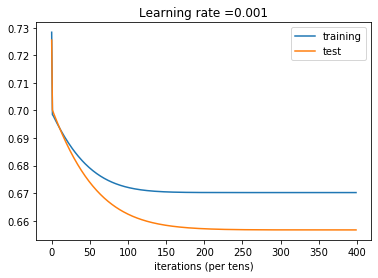

Parameters have been trained!
Train Accuracy:  60.67%
Test Accuracy: 63.79%


In [80]:
parameters = model(X_train, Y_train, X_val, Y_val,learning_rate=0.001, num_epochs=2000)